In [1]:
# ===== PHẦN 1: EDA VÀ XỬ LÝ DỮ LIỆU =====
# Mở terminal gõ: pip install -r requirements.txt, hoặc tạo cell và thêm "%" phía trước nếu dùng Google Colab, thêm "!" phía trước nếu dùng Kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Thiết lập style cho plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load dữ liệu
train = pd.read_csv("data/dataset.csv")             # Thay đổi đường dẫn nếu cần
test = pd.read_csv("data/test.csv")                 # Thay đổi đường dẫn nếu cần
sample = pd.read_csv("data/sample_submission.csv")  # Thay đổi đường dẫn nếu cần

print("=== THÔNG TIN CƠ BẢN VỀ DỮ LIỆU ===")
print(f"Kích thước train: {train.shape}")
print(f"Kích thước test: {test.shape}")
print(f"Kích thước sample submission: {sample.shape}")

=== THÔNG TIN CƠ BẢN VỀ DỮ LIỆU ===
Kích thước train: (200000, 47)
Kích thước test: (200000, 46)
Kích thước sample submission: (200000, 3)


In [3]:
# 1. PHÂN TÍCH MÔ TẢ CƠ BẢN
print("\n=== THỐNG KÊ MÔ TẢ BIẾN TARGET ===")
print(train['sale_price'].describe())


=== THỐNG KÊ MÔ TẢ BIẾN TARGET ===
count    2.000000e+05
mean     5.841495e+05
std      4.170595e+05
min      5.029300e+04
25%      3.050000e+05
50%      4.599500e+05
75%      7.249500e+05
max      2.999950e+06
Name: sale_price, dtype: float64


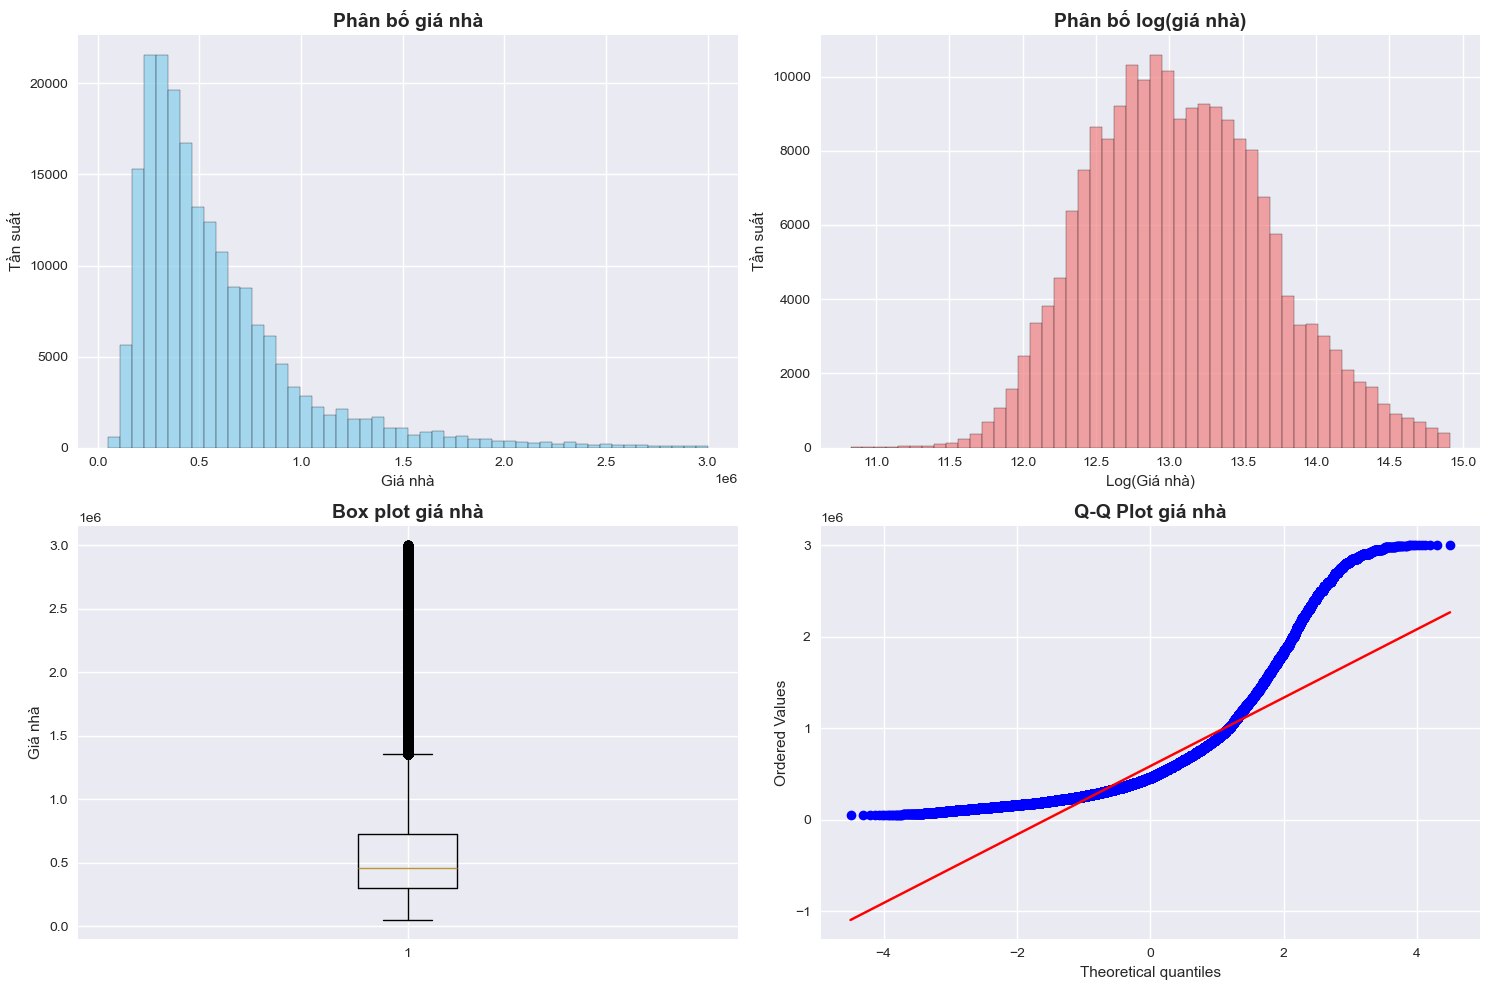

In [4]:
# 2. PHÂN TÍCH PHÂN BỐ GIÁ NHÀ
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram của giá nhà
axes[0,0].hist(train['sale_price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Phân bố giá nhà', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Giá nhà')
axes[0,0].set_ylabel('Tần suất')

# Log-scale histogram
axes[0,1].hist(np.log(train['sale_price']), bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Phân bố log(giá nhà)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Log(Giá nhà)')
axes[0,1].set_ylabel('Tần suất')

# Box plot
axes[1,0].boxplot(train['sale_price'])
axes[1,0].set_title('Box plot giá nhà', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Giá nhà')

# Q-Q plot
from scipy import stats
stats.probplot(train['sale_price'], dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot giá nhà', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Nhận xét giá nhà
- **Histogram gốc**: Giá nhà lệch phải mạnh, nhiều outlier > 1 triệu.
- **Log(Giá nhà)**: Gần với phân phối chuẩn, phù hợp cho mô hình hồi quy.
- **Box plot**: Median khoảng 400K, outlier rất nhiều.
- **Q-Q Plot**: Lệch khỏi đường chuẩn → không phân phối chuẩn.

**Kết luận**: Nên dùng `log(price)` để cải thiện tính phân phối và độ ổn định cho mô hình.


=== PHÂN TÍCH MISSING VALUES ===
         Column  Missing Count  Missing Percentage
3      sale_nbr          42182             21.0910
12  subdivision          17550              8.7750
46    submarket           1717              0.8585


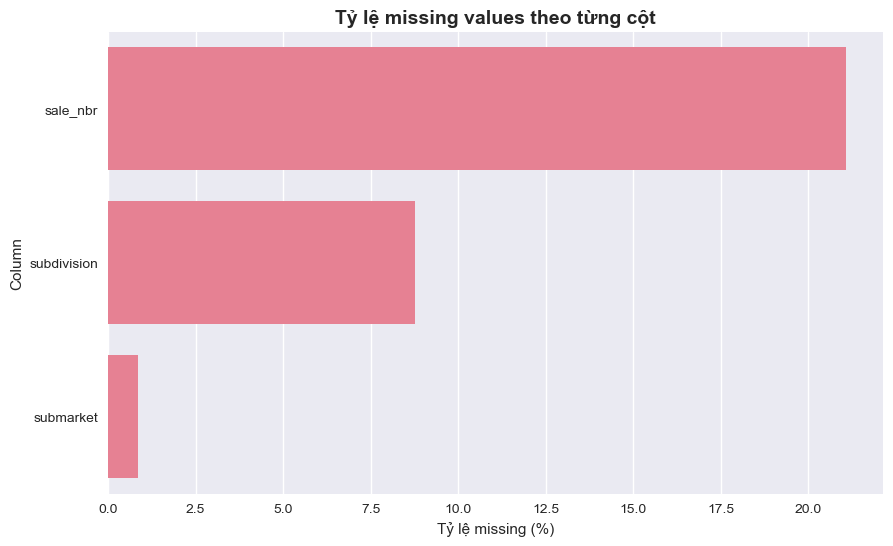

In [5]:
# 3. PHÂN TÍCH MISSING VALUES
print("\n=== PHÂN TÍCH MISSING VALUES ===")
missing_data = train.isnull().sum()
missing_percent = 100 * missing_data / len(train)
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.barplot(data=missing_df, x='Missing Percentage', y='Column')
plt.title('Tỷ lệ missing values theo từng cột', fontsize=14, fontweight='bold')
plt.xlabel('Tỷ lệ missing (%)')
plt.show()


=== PHÂN TÍCH CÁC BIẾN QUAN TRỌNG ===
Top 15 biến có correlation cao nhất với sale_price:
sale_price          1.000000
sqft                0.466253
grade               0.464287
imp_val             0.455197
land_val            0.412339
sqft_1              0.304217
sale_nbr            0.278285
latitude            0.272874
view_territorial    0.235627
bath_full           0.226203
beds                0.225255
view_lakewash       0.202914
stories             0.201907
sqft_fbsmt          0.199307
bath_3qtr           0.177927
Name: sale_price, dtype: float64


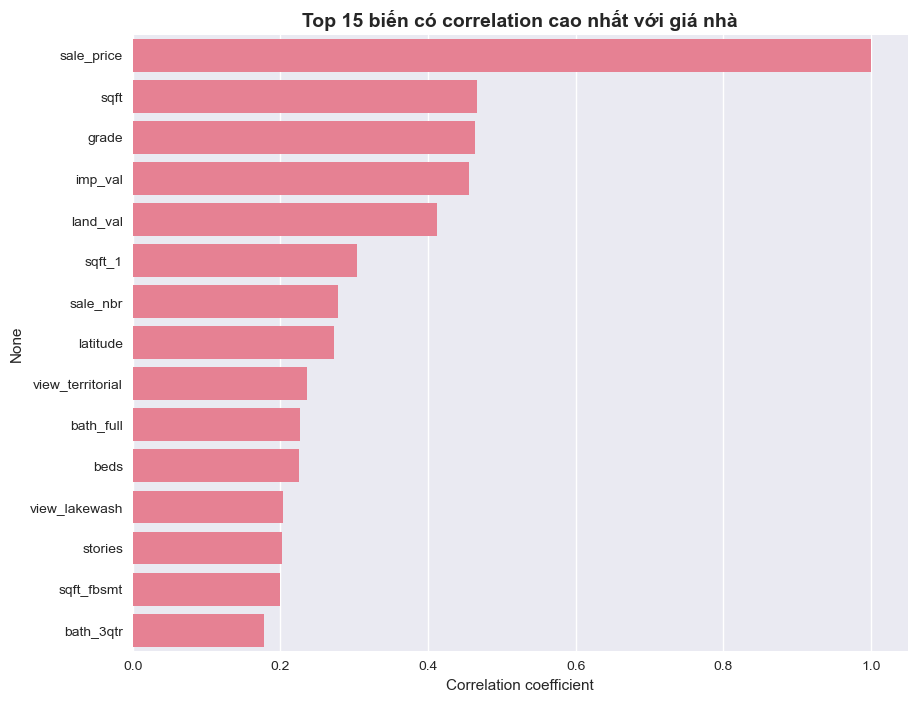

In [6]:
# 4. PHÂN TÍCH CÁC BIẾN QUAN TRỌNG
print("\n=== PHÂN TÍCH CÁC BIẾN QUAN TRỌNG ===")

# Correlation với target
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
correlations = train[numeric_cols].corr()['sale_price'].sort_values(ascending=False)
print("Top 15 biến có correlation cao nhất với sale_price:")
print(correlations.head(15))

# Visualize top correlations
plt.figure(figsize=(10, 8))
top_corr = correlations.head(15)
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top 15 biến có correlation cao nhất với giá nhà', fontsize=14, fontweight='bold')
plt.xlabel('Correlation coefficient')
plt.show()


=== PHÂN TÍCH THEO THÀNH PHỐ ===
Thống kê giá nhà theo thành phố:
               count        mean     median        std
city                                                  
YARROW POINT      96  1539154.97  1400000.0  722455.83
CLYDE HILL       331  1419134.21  1300000.0  704350.90
MEDINA           291  1414820.69  1320000.0  699734.24
BEAUX ARTS        43  1352351.63  1185000.0  732232.82
MERCER ISLAND   2200  1214588.98  1056350.0  639292.43
HUNTS POINT       29  1141648.76   759000.0  725474.68
BELLEVUE       10691   837353.82   665000.0  556533.58
NEWCASTLE       1438   812485.33   698812.5  485514.45
SAMMAMISH       9563   769859.84   637950.0  464372.83
ISSAQUAH        3671   737346.82   614000.0  440516.88


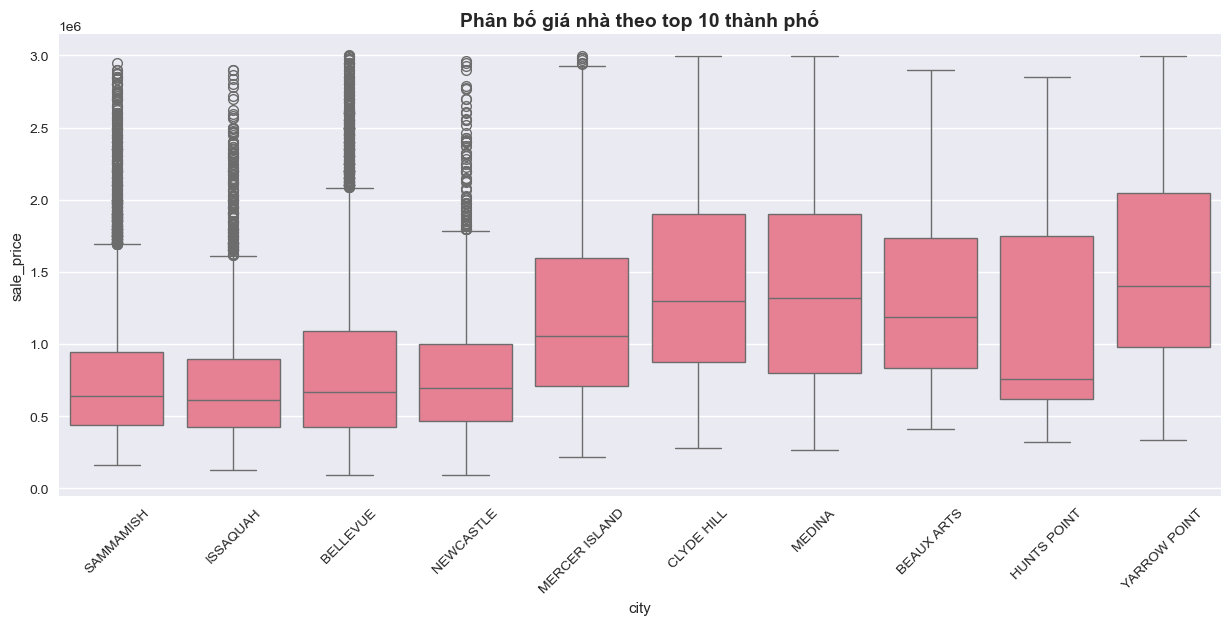

In [7]:
# 5. PHÂN TÍCH THEO THÀNH PHỐ
print("\n=== PHÂN TÍCH THEO THÀNH PHỐ ===")
city_stats = train.groupby('city')['sale_price'].agg(['count', 'mean', 'median', 'std']).round(2)
city_stats = city_stats.sort_values('mean', ascending=False)
print("Thống kê giá nhà theo thành phố:")
print(city_stats.head(10))

# Visualize price by city
plt.figure(figsize=(15, 6))
top_cities = city_stats.head(10).index
train_top_cities = train[train['city'].isin(top_cities)]
sns.boxplot(data=train_top_cities, x='city', y='sale_price')
plt.xticks(rotation=45)
plt.title('Phân bố giá nhà theo top 10 thành phố', fontsize=14, fontweight='bold')
plt.show()

## Phân tích giá nhà theo các thành phố
- **Yarrow Point, Hunts Point, Clyde Hill, Medina** có giá nhà **cao nhất**, median > 1.5 triệu.
- **Bellevue, Sammamish, Issaquah** giá nhà thấp hơn, median ~600K–700K.
- **Outliers xuất hiện nhiều** ở các thành phố đông dân như Sammamish, Issaquah → nhiều căn giá rất cao.

**Kết luận**:
- Các thành phố như Medina & Clyde Hill có giá trị bất động sản **cao vượt trội**, nên cân nhắc thêm biến `city` vào mô hình dự đoán.

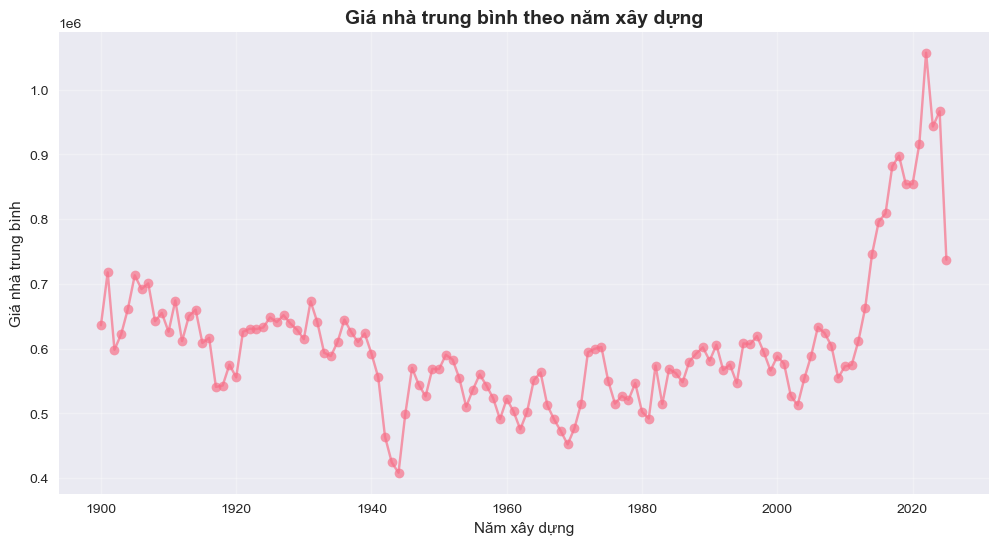

In [8]:
# 6. PHÂN TÍCH THEO NĂM XÂY DỰNG
plt.figure(figsize=(12, 6))
year_built_stats = train.groupby('year_built')['sale_price'].mean()
plt.plot(year_built_stats.index, year_built_stats.values, marker='o', alpha=0.7)
plt.title('Giá nhà trung bình theo năm xây dựng', fontsize=14, fontweight='bold')
plt.xlabel('Năm xây dựng')
plt.ylabel('Giá nhà trung bình')
plt.grid(True, alpha=0.3)
plt.show()

## Giá nhà trung bình theo năm xây dựng

- Nhà xây sau **2010** có xu hướng giá **cao vượt trội**.
- Giai đoạn **1900–2000**: giá tương đối ổn định quanh mức 500K–650K.
- Giai đoạn từ **2010 trở đi**: tăng mạnh, đỉnh gần 1.1 triệu.

**Kết luận**:
- **Năm xây dựng** là biến quan trọng → nhà càng mới giá càng cao, đặc biệt từ sau 2010.
- Có thể dùng `year_built` hoặc `house_age` làm feature cho mô hình.

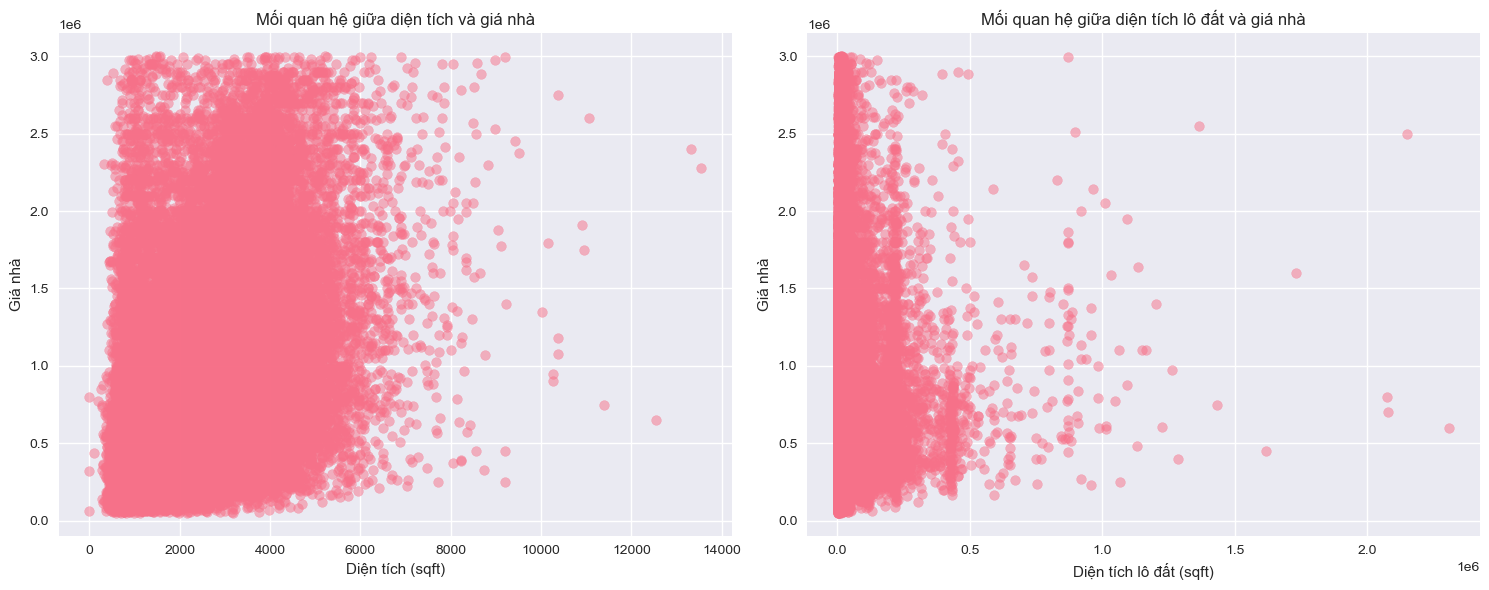

In [9]:
# 7. PHÂN TÍCH DIỆN TÍCH VÀ GIÁ NHÀ
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot sqft vs price
axes[0].scatter(train['sqft'], train['sale_price'], alpha=0.5)
axes[0].set_xlabel('Diện tích (sqft)')
axes[0].set_ylabel('Giá nhà')
axes[0].set_title('Mối quan hệ giữa diện tích và giá nhà')

# Scatter plot lot size vs price
axes[1].scatter(train['sqft_lot'], train['sale_price'], alpha=0.5)
axes[1].set_xlabel('Diện tích lô đất (sqft)')
axes[1].set_ylabel('Giá nhà')
axes[1].set_title('Mối quan hệ giữa diện tích lô đất và giá nhà')

plt.tight_layout()
plt.show()

## Phân tích mối quan hệ giữa diện tích và giá nhà

- **Trái: Diện tích nhà vs. Giá nhà**
  - Có xu hướng tuyến tính nhẹ: diện tích càng lớn, giá càng cao.
  - Nhưng dữ liệu bị nhiễu, có nhiều điểm nhỏ giá cao (có thể do vị trí, chất lượng).

- **Phải: Diện tích lô đất vs. Giá nhà**
  - Không có xu hướng rõ ràng.
  - Nhiều điểm ngoại lai với lô đất rất lớn nhưng giá không tương xứng → **biến này có thể không mạnh**.

**Kết luận**:
- Diện tích nhà (living space) hữu ích hơn diện tích lô đất để dự đoán giá.
- Cần chuẩn hóa hoặc loại bỏ outlier để làm rõ tương quan hơn.


=== PHÁT HIỆN VÀ XỬ LÝ OUTLIERS ===
Số lượng outliers trong sale_price: 11736
Tỷ lệ outliers: 5.87%
Giới hạn dưới: -324,925
Giới hạn trên: 1,354,875


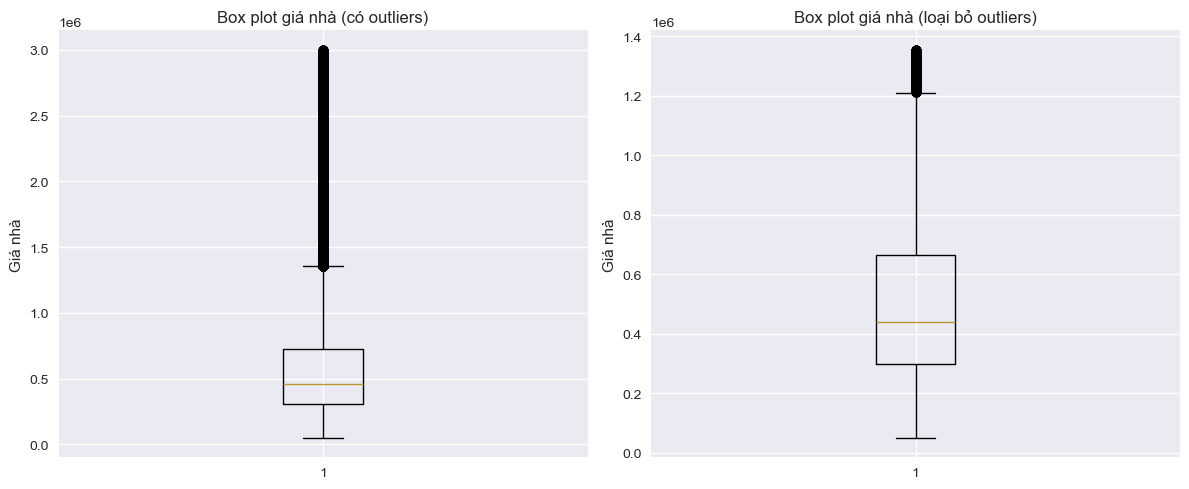

In [10]:
# 8. XỬ LÝ OUTLIERS
print("\n=== PHÁT HIỆN VÀ XỬ LÝ OUTLIERS ===")

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Phát hiện outliers cho sale_price
outliers, lower, upper = detect_outliers_iqr(train, 'sale_price')
print(f"Số lượng outliers trong sale_price: {len(outliers)}")
print(f"Tỷ lệ outliers: {len(outliers)/len(train)*100:.2f}%")
print(f"Giới hạn dưới: {lower:,.0f}")
print(f"Giới hạn trên: {upper:,.0f}")

# Visualize outliers
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.boxplot(train['sale_price'])
plt.title('Box plot giá nhà (có outliers)')
plt.ylabel('Giá nhà')

plt.subplot(1, 2, 2)
train_no_outliers = train[(train['sale_price'] >= lower) & (train['sale_price'] <= upper)]
plt.boxplot(train_no_outliers['sale_price'])
plt.title('Box plot giá nhà (loại bỏ outliers)')
plt.ylabel('Giá nhà')

plt.tight_layout()
plt.show()

In [11]:
# 9. FEATURE ENGINEERING
print("\n=== FEATURE ENGINEERING ===")

def feature_engineering(df):
    """
    Thực hiện feature engineering cho dataset
    """
    df = df.copy()
    
    # Xử lý ngày tháng
    df['sale_date'] = pd.to_datetime(df['sale_date'])
    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month
    df['sale_day'] = df['sale_date'].dt.day
    df['sale_quarter'] = df['sale_date'].dt.quarter
    df['sale_dayofweek'] = df['sale_date'].dt.dayofweek
    
    # Tính tuổi nhà
    df['house_age'] = df['sale_year'] - df['year_built']
    df['years_since_reno'] = df['sale_year'] - df['year_reno']
    
    # Tỷ lệ diện tích
    df['sqft_ratio'] = df['sqft'] / (df['sqft_lot'] + 1)  # +1 để tránh chia cho 0
    df['basement_ratio'] = df['sqft_fbsmt'] / (df['sqft'] + 1)
    
    # Tổng số phòng tắm
    df['total_bath'] = df['bath_full'] + df['bath_3qtr']*0.75 + df['bath_half']*0.5
    
    # Tổng diện tích garage
    df['total_garage'] = df['garb_sqft'] + df['gara_sqft']
    
    # Số lượng view
    view_cols = [col for col in df.columns if col.startswith('view_')]
    df['total_views'] = df[view_cols].sum(axis=1)
    
    # Giá trị tổng tài sản
    df['total_value'] = df['land_val'] + df['imp_val']
    df['value_per_sqft'] = df['total_value'] / (df['sqft'] + 1)
    
    # Binning cho một số biến liên tục
    df['grade_category'] = pd.cut(df['grade'], bins=5, labels=['Low', 'Below_Avg', 'Average', 'Above_Avg', 'High'])
    df['condition_category'] = pd.cut(df['condition'], bins=3, labels=['Poor', 'Average', 'Good'])
    
    # Interaction features
    df['sqft_grade_interaction'] = df['sqft'] * df['grade']
    df['age_condition_interaction'] = df['house_age'] * df['condition']
    
    return df

# Áp dụng feature engineering
print("Đang thực hiện feature engineering...")
train_fe = feature_engineering(train)
test_fe = feature_engineering(test)

print("Các feature mới được tạo:")
original_cols = set(train.columns)
new_cols = set(train_fe.columns) - original_cols
for feature in sorted(new_cols):
    print(f"- {feature}")


=== FEATURE ENGINEERING ===
Đang thực hiện feature engineering...
Các feature mới được tạo:
- age_condition_interaction
- basement_ratio
- condition_category
- grade_category
- house_age
- sale_day
- sale_dayofweek
- sale_month
- sale_quarter
- sale_year
- sqft_grade_interaction
- sqft_ratio
- total_bath
- total_garage
- total_value
- total_views
- value_per_sqft
- years_since_reno


In [12]:
# 10. XỬ LÝ MISSING VALUES CHI TIẾT
print("\n=== XỬ LÝ MISSING VALUES CHI TIẾT ===")

def handle_missing_values(df, is_train=True):
    """
    Xử lý missing values một cách chi tiết
    """
    df = df.copy()
    
    # Xử lý missing values cho từng cột cụ thể
    
    # sale_nbr: Fill với median
    if 'sale_nbr' in df.columns:
        df['sale_nbr'].fillna(df['sale_nbr'].median(), inplace=True)
    
    # subdivision: Fill với 'Unknown'
    if 'subdivision' in df.columns:
        df['subdivision'].fillna('Unknown', inplace=True)
    
    # submarket: Fill với 'Unknown'  
    if 'submarket' in df.columns:
        df['submarket'].fillna('Unknown', inplace=True)
    
    # Các categorical columns khác
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col not in ['subdivision', 'submarket']:
            df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown', inplace=True)
    
    # Các numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if col not in ['id', 'sale_price']:  # Không fill cho id và target
            df[col].fillna(df[col].median(), inplace=True)
    
    return df

# Xử lý missing values
train_processed = handle_missing_values(train_fe, is_train=True)
test_processed = handle_missing_values(test_fe, is_train=False)

print("Missing values sau khi xử lý:")
print("Train:", train_processed.isnull().sum().sum())
print("Test:", test_processed.isnull().sum().sum())


=== XỬ LÝ MISSING VALUES CHI TIẾT ===
Missing values sau khi xử lý:
Train: 0
Test: 0


In [13]:
# 11. ENCODING CATEGORICAL VARIABLES
print("\n=== ENCODING CATEGORICAL VARIABLES ===")

from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle

def encode_categorical_variables(train_df, test_df):
    """
    Encode categorical variables
    """
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    
    # Lấy danh sách categorical columns
    categorical_cols = train_encoded.select_dtypes(include=['object']).columns.tolist()
    
    # Loại bỏ sale_date nếu còn
    if 'sale_date' in categorical_cols:
        categorical_cols.remove('sale_date')
    
    label_encoders = {}
    
    for col in categorical_cols:
        print(f"Encoding {col}...")
        le = LabelEncoder()
        
        # Kết hợp data từ train và test để đảm bảo consistency
        combined_data = pd.concat([
            train_encoded[col].astype(str), 
            test_encoded[col].astype(str)
        ], ignore_index=True)
        
        # Fit encoder trên combined data
        le.fit(combined_data)
        
        # Transform
        train_encoded[col] = le.transform(train_encoded[col].astype(str))
        test_encoded[col] = le.transform(test_encoded[col].astype(str))
        
        # Lưu encoder
        label_encoders[col] = le
    
    return train_encoded, test_encoded, label_encoders

# Encode categorical variables
train_encoded, test_encoded, label_encoders = encode_categorical_variables(train_processed, test_processed)

print(f"Đã encode {len(label_encoders)} categorical variables")


=== ENCODING CATEGORICAL VARIABLES ===
Encoding sale_warning...
Encoding join_status...
Encoding city...
Encoding zoning...
Encoding subdivision...
Encoding submarket...
Đã encode 6 categorical variables


In [14]:
# 12. CHUẨN HÓA NUMERICAL FEATURES
print("\n=== CHUẨN HÓA NUMERICAL FEATURES ===")

def normalize_features(train_df, test_df, target_col='sale_price'):
    """
    Chuẩn hóa numerical features
    """
    train_normalized = train_df.copy()
    test_normalized = test_df.copy()
    
    # Loại bỏ các cột không cần chuẩn hóa
    exclude_cols = ['id', 'sale_date']
    if target_col in train_normalized.columns:
        exclude_cols.append(target_col)
    
    # Lấy numerical columns
    numerical_cols = train_normalized.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in exclude_cols]
    
    print(f"Chuẩn hóa {len(numerical_cols)} numerical features")
    
    # Fit scaler trên training data
    scaler = StandardScaler()
    scaler.fit(train_normalized[numerical_cols])
    
    # Transform
    train_normalized[numerical_cols] = scaler.transform(train_normalized[numerical_cols])
    test_normalized[numerical_cols] = scaler.transform(test_normalized[numerical_cols])
    
    return train_normalized, test_normalized, scaler

# Chuẩn hóa features
train_final, test_final, scaler = normalize_features(train_encoded, test_encoded)

print("Hoàn thành chuẩn hóa dữ liệu!")


=== CHUẨN HÓA NUMERICAL FEATURES ===
Chuẩn hóa 60 numerical features
Hoàn thành chuẩn hóa dữ liệu!


In [15]:
# 13. CHUẨN BỊ DỮ LIỆU CHO MODELING
print("\n=== CHUẨN BỊ DỮ LIỆU CHO MODELING ===")

# Loại bỏ các cột không cần thiết
columns_to_drop = ['sale_date']
if 'sale_date' in train_final.columns:
    train_final = train_final.drop(columns=['sale_date'])
if 'sale_date' in test_final.columns:
    test_final = test_final.drop(columns=['sale_date'])

# Tách features và target
X_train = train_final.drop(columns=['sale_price'], errors='ignore')
y_train = train_final['sale_price'] if 'sale_price' in train_final.columns else None
X_test = test_final.copy()

print(f"Shape của X_train: {X_train.shape}")
print(f"Shape của y_train: {y_train.shape if y_train is not None else 'None'}")
print(f"Shape của X_test: {X_test.shape}")

# Kiểm tra consistency giữa train và test
print(f"Columns in train but not in test: {set(X_train.columns) - set(X_test.columns)}")
print(f"Columns in test but not in train: {set(X_test.columns) - set(X_train.columns)}")

# Đảm bảo cùng columns
common_columns = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_columns]
X_test = X_test[common_columns]

print(f"Final X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")


=== CHUẨN BỊ DỮ LIỆU CHO MODELING ===
Shape của X_train: (200000, 63)
Shape của y_train: (200000,)
Shape của X_test: (200000, 63)
Columns in train but not in test: set()
Columns in test but not in train: set()
Final X_train shape: (200000, 63)
Final X_test shape: (200000, 63)


In [16]:
# 14. LƯU DỮ LIỆU ĐÃ XỬ LÝ
print("\n=== LƯU DỮ LIỆU ĐÃ XỬ LÝ ===")

# Tạo thư mục processed_data nếu chưa có
import os
os.makedirs('processed_data', exist_ok=True)

# Lưu dữ liệu chính
X_train.to_csv('processed_data/X_train.csv', index=False)
X_test.to_csv('processed_data/X_test.csv', index=False)

if y_train is not None:
    y_train.to_csv('processed_data/y_train.csv', index=False)

# Lưu test ids để tạo submission
test_ids = test['id']
test_ids.to_csv('processed_data/test_ids.csv', index=False)

# Lưu metadata
metadata = {
    'train_shape': X_train.shape,
    'test_shape': X_test.shape,
    'features': list(X_train.columns),
    'categorical_features': list(label_encoders.keys()),
    'target_stats': {
        'mean': float(y_train.mean()) if y_train is not None else None,
        'std': float(y_train.std()) if y_train is not None else None,
        'min': float(y_train.min()) if y_train is not None else None,
        'max': float(y_train.max()) if y_train is not None else None
    }
}

import json
with open('processed_data/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Lưu encoders và scaler
with open('processed_data/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

with open('processed_data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Lưu dữ liệu gốc đã feature engineering (trước khi encode và scale)
train_fe.to_csv('processed_data/train_with_features.csv', index=False)
test_fe.to_csv('processed_data/test_with_features.csv', index=False)

print("✅ Đã lưu các file sau:")
print("  📁 processed_data/")
print("    ├── X_train.csv - Features training (đã xử lý)")
print("    ├── X_test.csv - Features test (đã xử lý)")  
print("    ├── y_train.csv - Target training")
print("    ├── test_ids.csv - IDs cho submission")
print("    ├── metadata.json - Thông tin metadata")
print("    ├── label_encoders.pkl - Label encoders")
print("    ├── scaler.pkl - StandardScaler")
print("    ├── train_with_features.csv - Train data với features mới")
print("    └── test_with_features.csv - Test data với features mới")


=== LƯU DỮ LIỆU ĐÃ XỬ LÝ ===
✅ Đã lưu các file sau:
  📁 processed_data/
    ├── X_train.csv - Features training (đã xử lý)
    ├── X_test.csv - Features test (đã xử lý)
    ├── y_train.csv - Target training
    ├── test_ids.csv - IDs cho submission
    ├── metadata.json - Thông tin metadata
    ├── label_encoders.pkl - Label encoders
    ├── scaler.pkl - StandardScaler
    ├── train_with_features.csv - Train data với features mới
    └── test_with_features.csv - Test data với features mới


In [17]:
# 15. SUMMARY REPORT
print("\n" + "="*60)
print("                    EDA & PREPROCESSING SUMMARY")
print("="*60)

print(f"\n📊 Dataset Information:")
print(f"   - Original train size: {train.shape}")
print(f"   - Original test size: {test.shape}")
print(f"   - Final processed train size: {X_train.shape}")
print(f"   - Final processed test size: {X_test.shape}")

print(f"\n🔧 Features Engineering:")
print(f"   - Original features: {len(train.columns)}")
print(f"   - Final features: {len(X_train.columns)}")
print(f"   - New features created: {len(X_train.columns) - len(train.columns) + 1}")  # +1 vì đã drop sale_price

print(f"\n🧹 Data Cleaning:")
print(f"   - Missing values handled: ✅")
print(f"   - Categorical variables encoded: {len(label_encoders)}")
print(f"   - Numerical features normalized: ✅")
print(f"   - Outliers analyzed: ✅")

print(f"\n📈 Target Variable (sale_price):")
if y_train is not None:
    print(f"   - Mean: ${y_train.mean():,.2f}")
    print(f"   - Median: ${y_train.median():,.2f}")
    print(f"   - Std: ${y_train.std():,.2f}")
    print(f"   - Range: ${y_train.min():,.2f} - ${y_train.max():,.2f}")

print(f"\n✅ Ready for modeling!")
print("="*60)


                    EDA & PREPROCESSING SUMMARY

📊 Dataset Information:
   - Original train size: (200000, 47)
   - Original test size: (200000, 46)
   - Final processed train size: (200000, 63)
   - Final processed test size: (200000, 63)

🔧 Features Engineering:
   - Original features: 47
   - Final features: 63
   - New features created: 17

🧹 Data Cleaning:
   - Missing values handled: ✅
   - Categorical variables encoded: 6
   - Numerical features normalized: ✅
   - Outliers analyzed: ✅

📈 Target Variable (sale_price):
   - Mean: $584,149.49
   - Median: $459,950.00
   - Std: $417,059.52
   - Range: $50,293.00 - $2,999,950.00

✅ Ready for modeling!
